# Notebook for `HDDM_docker`

Author: Hu Chuan-Peng (PhD) @Nanjing Normal University
E-mail: hcp4715@hotmail.com


This is a notebook for an introductary paper of this docker image, which might be titled as *HDDM_docker: A docker image for reproducible Bayesian hierarchical drift-diffusion modelling*. 

In this notebook, we will demostrate how to conduct HDDM analysis with docker image `hcp4715/hddm:tutorial`.

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


### Import func for converting HDDM objects to `InferenceData`

The scripts are stored at the `scripts` folder, which need to be added to the path temporarily.

In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
scripts_dir = '/home/jovyan/hddm/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from plot_ppc_by_cond import plot_ppc_by_cond

#### Load the example data Cavanaght et al. (2011)

In [3]:
data_cavanagh = hddm.load_csv(os.path.join(os.path.dirname(hddm.__file__), 
                                           'examples', 
                                           'cavanagh_theta_nn.csv'))
data_cavanagh.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


#### Define functions for parallel processing

In [4]:
%%time
# M0_0: base model: simplified
def ms0(id, df=None, samples=None, burn=None, thin=1, save_name="ms0"): 
    # for HDDM models, adding this print func can prevent warnings that would occur
    #  when running parallel processing in jupyter
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def ms4(id, df=None, samples=None, burn=None, thin = 1, save_name="ms4"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 16.2 µs


#### Define parameter for model fitting and converting

In [5]:
samples = 300  # number of MCMC sample; Cavanagh et al. 2011 used 30,000 and 10, 000 burn.
burn = 100     # number of burn in
nppc = 50      # number of posterior predictive, super slow
thin = 1       # thining
chains = 4     # number of chains, default is 4
test_mode = False  # Test model will only run the simplest model
savefile=True      # save file or not, only "True" is available for now.
savetag = "tmp"    # tag added to saved files.

In [6]:
%%time
# If test_mode is true, we will only run the simplest model
if test_mode:
    model_func = ms0

else: 
    model_func = [ms0,  
                  ms4]

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 8.34 µs


#### Fit the model and convert to Inference data

In [7]:
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=model_func,
                            samples=samples, 
                            nppc=nppc, 
                            burn=burn, 
                            thin=thin, 
                            chains=chains, 
                            savefile=savefile,
                            savetag=savetag)

start model fitting for ms0
running chain 0 for model ms0_tmp

  0%|          | 0/4 [00:00<?, ?it/s]


running chain 1 for model ms0_tmp
running chain 2 for model ms0_tmp
running chain 3 for model ms0_tmp


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 ------------     33%                  ] 99 of 300 complete in 4.7 secc[-                 4%                  ] 12 of 300 complete in 0.5 sec[-                 4%                  ] 12 of 300 complete in 0.5 sec[-                 4%                  ] 12 of 300 complete in 0.5 sec[--                7%                  ] 23 of 300 complete in 1.0 sec[--                7%                  ] 23 of 300 complete in 1.0 sec[--                7%                  ] 23 of 300 complete in 1.1 sec[--                7%                  ] 23 of 300 complete in 1.0 sec[----             11%                  ] 34 of 300 complete in 1.5 sec[----             11%                  ] 34 of 300 complete in 1.6 sec[----             11%                  ] 34 of 300 complete in 1.6 sec[----             11%                  ] 34 of 300 complete in 1.6 sec[-----            14%                  ] 44 of 300 complete in 2.1 sec[-----            15%                  ] 45 of 300 complete in 2.1 sec[-----            1

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 0.7 sec[----------       28%                  ] 4 of 14 complete in 0.7 sec[----------       28%                  ] 4 of 14 complete in 0.7 sec[----------       28%                  ] 4 of 14 complete in 0.7 sec[-------------    35%                  ] 5 of 14 complete in 1.4 sec[-------------    35%                  ] 5 of 14 complete in 1.4 sec[-------------    35%                  ] 5 of 14 complete in 1.4 sec[-------------    35%                  ] 5 of 14 complete in 1.4 sec[---------------- 42%                  ] 6 of 14 complete in 2.0 sec[---------------- 42%                  ] 6 of 14 complete in 2.0 sec[---------------- 42%                  ] 6 of 14 complete in 2.1 sec[---------------- 42%                  ] 6 of 14 complete in 2.0 sec[--------------

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [-----------------64%----              ] 9 of 14 complete in 0.5 sec[-----------------64%----              ] 9 of 14 complete in 0.5 sec[-----------------71%-------           ] 10 of 14 complete in 0.6 sec[-----------------71%-------           ] 10 of 14 complete in 0.6 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[-----------------100%-----------------] 14 of 14 complete in 1.0 sec[-------------------114%--------------------] 16 of 14 complete in 1.1 sec[------------------107%------------------] 15 of 14 complete in 1.0 sec[---------------------121%---------------------] 17 of 14 complete in 1.1 sec[---------------------121%---------------------] 17 of 14 complete in 1.2 secstart model fitting for ms4


  0%|          | 0/4 [00:00<?, ?it/s]

running chain 0 for model ms4_tmp
running chain 2 for model ms4_tmpAdding these covariates:

['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
running chain 1 for model ms4_tmp
Adding these covariates:running chain 3 for model ms4_tmp
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]

Adding these covariates:Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]

['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 2 of 300 complete in 0.6 sec[                  0%                  ] 2 of 300 complete in 0.7 sec[                  0%                  ] 2 of 300 complete in 0.6 sec[                  0%                  ] 2 of 300 complete in 0.7 sec[                  1%                  ] 3 of 300 complete in 1.5 sec[                  1%                  ] 3 of 300 complete in 1.7 sec[                  1%                  ] 3 of 300 complete in 1.6 sec[                  1%                  ] 3 of 300 complete in 1.8 sec[                  1%                  ] 4 of 300 complete in 2.1 sec[                  1%                  ] 4 of 300 complete in 2.6 sec[                  1%                  ] 4 of 300 complete in 2.7 sec[                  1%                  ] 4 of 300 complete in 2.9 sec[                  1%                  ] 5 of 300 complete in 3.0 sec[                  1%                  ] 5 of 300 complete in 3.6 sec[                  1%            

 [---              10%                  ] 30 of 300 complete in 30.6 sec[----             10%                  ] 32 of 300 complete in 31.4 sec[---              10%                  ] 31 of 300 complete in 31.3 sec[----             10%                  ] 32 of 300 complete in 31.6 sec[---              10%                  ] 31 of 300 complete in 31.7 sec[----             11%                  ] 33 of 300 complete in 32.4 sec[----             10%                  ] 32 of 300 complete in 32.4 sec[----             11%                  ] 33 of 300 complete in 32.6 sec[----             10%                  ] 32 of 300 complete in 32.9 sec[----             11%                  ] 34 of 300 complete in 33.4 sec[----             11%                  ] 34 of 300 complete in 33.7 sec[----             11%                  ] 33 of 300 complete in 33.6 sec[----             11%                  ] 33 of 300 complete in 33.8 sec[----             11%                  ] 35 of 300 complete in 34.5 sec[----

 [-------          19%                  ] 59 of 300 complete in 62.0 sec[-------          20%                  ] 60 of 300 complete in 62.4 sec[-------          20%                  ] 61 of 300 complete in 62.5 sec[-------          20%                  ] 61 of 300 complete in 62.8 sec[-------          20%                  ] 60 of 300 complete in 63.2 sec[-------          20%                  ] 62 of 300 complete in 63.5 sec[-------          20%                  ] 61 of 300 complete in 63.6 sec[-------          20%                  ] 62 of 300 complete in 64.1 sec[-------          20%                  ] 61 of 300 complete in 64.3 sec[-------          21%                  ] 63 of 300 complete in 64.6 sec[-------          20%                  ] 62 of 300 complete in 64.7 sec[-------          21%                  ] 63 of 300 complete in 65.1 sec[-------          20%                  ] 62 of 300 complete in 65.3 sec[--------         21%                  ] 64 of 300 complete in 65.7 sec[----

 [-----------      30%                  ] 90 of 300 complete in 93.5 sec[-----------      29%                  ] 88 of 300 complete in 93.8 sec[-----------      29%                  ] 88 of 300 complete in 93.9 sec[-----------      30%                  ] 91 of 300 complete in 94.4 sec[-----------      30%                  ] 91 of 300 complete in 94.6 sec[-----------      29%                  ] 89 of 300 complete in 95.0 sec[-----------      29%                  ] 89 of 300 complete in 95.2 sec[-----------      30%                  ] 92 of 300 complete in 95.5 sec[-----------      30%                  ] 92 of 300 complete in 95.8 sec[-----------      30%                  ] 90 of 300 complete in 96.1 sec[-----------      30%                  ] 90 of 300 complete in 96.3 sec[-----------      31%                  ] 93 of 300 complete in 96.6 sec[-----------      31%                  ] 93 of 300 complete in 96.9 sec[-----------      30%                  ] 91 of 300 complete in 97.0 sec[----

 [--------------   39%                  ] 117 of 300 complete in 124.3 sec[---------------  40%                  ] 120 of 300 complete in 124.5 sec[--------------   38%                  ] 116 of 300 complete in 124.4 sec[--------------   39%                  ] 118 of 300 complete in 124.8 sec[---------------  40%                  ] 121 of 300 complete in 125.5 sec[--------------   39%                  ] 118 of 300 complete in 125.5 sec[--------------   39%                  ] 117 of 300 complete in 125.6 sec[---------------  39%                  ] 119 of 300 complete in 126.0 sec[---------------  40%                  ] 122 of 300 complete in 126.5 sec[---------------  39%                  ] 119 of 300 complete in 126.6 sec[--------------   39%                  ] 118 of 300 complete in 126.8 sec[---------------  40%                  ] 120 of 300 complete in 127.1 sec[---------------  41%                  ] 123 of 300 complete in 127.6 sec[---------------  40%                  ] 120 of 30

 [-----------------48%                  ] 144 of 300 complete in 155.3 sec[-----------------49%                  ] 149 of 300 complete in 155.4 sec[-----------------49%                  ] 147 of 300 complete in 155.8 sec[-----------------48%                  ] 144 of 300 complete in 156.0 sec[-----------------48%                  ] 145 of 300 complete in 156.4 sec[-----------------50%                  ] 150 of 300 complete in 156.7 sec[-----------------49%                  ] 148 of 300 complete in 156.9 sec[-----------------48%                  ] 145 of 300 complete in 157.1 sec[-----------------48%                  ] 146 of 300 complete in 157.3 sec[-----------------50%                  ] 151 of 300 complete in 157.8 sec[-----------------49%                  ] 149 of 300 complete in 157.9 sec[-----------------48%                  ] 146 of 300 complete in 158.0 sec[-----------------49%                  ] 147 of 300 complete in 158.4 sec[-----------------50%                  ] 152 of 30

 [-----------------57%-                 ] 172 of 300 complete in 187.5 sec[-----------------57%-                 ] 173 of 300 complete in 187.6 sec[-----------------58%--                ] 174 of 300 complete in 188.1 sec[-----------------59%--                ] 178 of 300 complete in 188.4 sec[-----------------57%-                 ] 173 of 300 complete in 188.7 sec[-----------------58%--                ] 174 of 300 complete in 188.7 sec[-----------------58%--                ] 175 of 300 complete in 189.2 sec[-----------------59%--                ] 179 of 300 complete in 189.5 sec[-----------------58%--                ] 175 of 300 complete in 189.6 sec[-----------------58%--                ] 174 of 300 complete in 190.1 sec[-----------------58%--                ] 176 of 300 complete in 190.3 sec[-----------------60%--                ] 180 of 300 complete in 190.5 sec[-----------------58%--                ] 176 of 300 complete in 190.5 sec[-----------------58%--                ] 175 of 30

 -----------------72%-------           ] 218 of 300 complete in 238.6 secc[-----------------67%-----             ] 203 of 300 complete in 219.5 sec[-----------------67%-----             ] 203 of 300 complete in 219.7 sec[-----------------68%-----             ] 205 of 300 complete in 220.1 sec[-----------------68%-----             ] 204 of 300 complete in 220.5 sec[-----------------66%-----             ] 200 of 300 complete in 220.8 sec[-----------------68%-----             ] 204 of 300 complete in 221.0 sec[-----------------68%------            ] 206 of 300 complete in 221.3 sec[-----------------68%-----             ] 205 of 300 complete in 221.7 sec[-----------------67%-----             ] 201 of 300 complete in 221.9 sec[-----------------69%------            ] 207 of 300 complete in 222.4 sec[-----------------68%-----             ] 205 of 300 complete in 222.5 sec[-----------------68%------            ] 206 of 300 complete in 222.8 sec[-----------------67%-----             ] 202 of 30

 [-----------------75%--------          ] 227 of 300 complete in 251.9 sec[-----------------77%---------         ] 233 of 300 complete in 252.0 sec[-----------------76%---------         ] 229 of 300 complete in 252.2 sec[-----------------78%---------         ] 235 of 300 complete in 252.7 sec[-----------------76%--------          ] 228 of 300 complete in 253.0 sec[-----------------78%---------         ] 234 of 300 complete in 253.0 sec[-----------------76%---------         ] 230 of 300 complete in 253.4 sec[-----------------78%---------         ] 236 of 300 complete in 253.8 sec[-----------------76%---------         ] 229 of 300 complete in 254.0 sec[-----------------78%---------         ] 235 of 300 complete in 254.1 sec[-----------------77%---------         ] 231 of 300 complete in 254.8 sec[-----------------79%----------        ] 237 of 300 complete in 254.8 sec[-----------------76%---------         ] 230 of 300 complete in 255.1 sec[-----------------78%---------         ] 236 of 30

 [-----------------87%-------------     ] 261 of 300 complete in 282.7 sec[-----------------87%-------------     ] 263 of 300 complete in 283.0 sec[-----------------85%------------      ] 255 of 300 complete in 283.8 sec[-----------------87%-------------     ] 262 of 300 complete in 283.8 sec[-----------------88%-------------     ] 264 of 300 complete in 283.9 sec[-----------------86%------------      ] 258 of 300 complete in 283.9 sec[-----------------88%-------------     ] 265 of 300 complete in 284.9 sec[-----------------85%------------      ] 256 of 300 complete in 285.0 sec[-----------------87%-------------     ] 263 of 300 complete in 284.9 sec[-----------------86%------------      ] 259 of 300 complete in 285.2 sec[-----------------85%------------      ] 257 of 300 complete in 286.0 sec[-----------------88%-------------     ] 264 of 300 complete in 286.0 sec[-----------------88%-------------     ] 266 of 300 complete in 286.1 sec[-----------------86%------------      ] 260 of 30

 [-----------------97%----------------- ] 293 of 300 complete in 313.8 sec[-----------------95%----------------  ] 285 of 300 complete in 313.9 sec[-----------------94%---------------   ] 283 of 300 complete in 314.0 sec[-----------------96%----------------  ] 289 of 300 complete in 314.5 sec[-----------------98%----------------- ] 294 of 300 complete in 314.8 sec[-----------------95%----------------  ] 286 of 300 complete in 314.9 sec[-----------------94%---------------   ] 284 of 300 complete in 315.0 sec[-----------------96%----------------  ] 290 of 300 complete in 315.6 sec[-----------------98%----------------- ] 295 of 300 complete in 315.7 sec[-----------------95%----------------  ] 285 of 300 complete in 316.0 sec[-----------------95%----------------  ] 287 of 300 complete in 316.1 sec[-----------------98%----------------- ] 296 of 300 complete in 316.7 sec[-----------------97%----------------  ] 291 of 300 complete in 316.7 sec[-----------------95%----------------  ] 286 of 30

  0%|          | 0/4 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 54.3 sec[----------       28%                  ] 4 of 14 complete in 54.2 sec[----------       28%                  ] 4 of 14 complete in 54.2 sec[----------       28%                  ] 4 of 14 complete in 55.1 sec[-------------    35%                  ] 5 of 14 complete in 110.6 sec[-------------    35%                  ] 5 of 14 complete in 110.8 sec[-------------    35%                  ] 5 of 14 complete in 111.2 sec[-------------    35%                  ] 5 of 14 complete in 112.3 sec[---------------- 42%                  ] 6 of 14 complete in 163.4 sec[---------------- 42%                  ] 6 of 14 complete in 163.7 sec[---------------- 42%                  ] 6 of 14 complete in 163.9 sec[---------------- 42%                  ] 6 of 14 complete in 166.

  0%|          | 0/4 [00:00<?, ?it/s]


started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 17.7 sec[----------       28%                  ] 4 of 14 complete in 18.0 sec[----------       28%                  ] 4 of 14 complete in 18.0 sec[----------       28%                  ] 4 of 14 complete in 18.7 sec[-------------    35%                  ] 5 of 14 complete in 35.6 sec[-------------    35%                  ] 5 of 14 complete in 36.1 sec[-------------    35%                  ] 5 of 14 complete in 36.1 sec[-------------    35%                  ] 5 of 14 complete in 37.6 sec[---------------- 42%                  ] 6 of 14 complete in 53.2 sec[---------------- 42%                  ] 6 of 14 complete in 53.8 sec[---------------- 42%                  ] 6 of 14 complete in 53.8 sec[---------------- 42%                  ] 6 of 14 complete in 55.7 sec[-

## Bayesian modelling with `ArviZ`

### Model diagnosis

#### Visual inspection

In [8]:
InfData

{'ms0': Inference data with groups:
 	> posterior
 	> posterior_predictive
 	> log_likelihood
 	> observed_data,
 'ms4': Inference data with groups:
 	> posterior
 	> posterior_predictive
 	> log_likelihood
 	> observed_data}

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

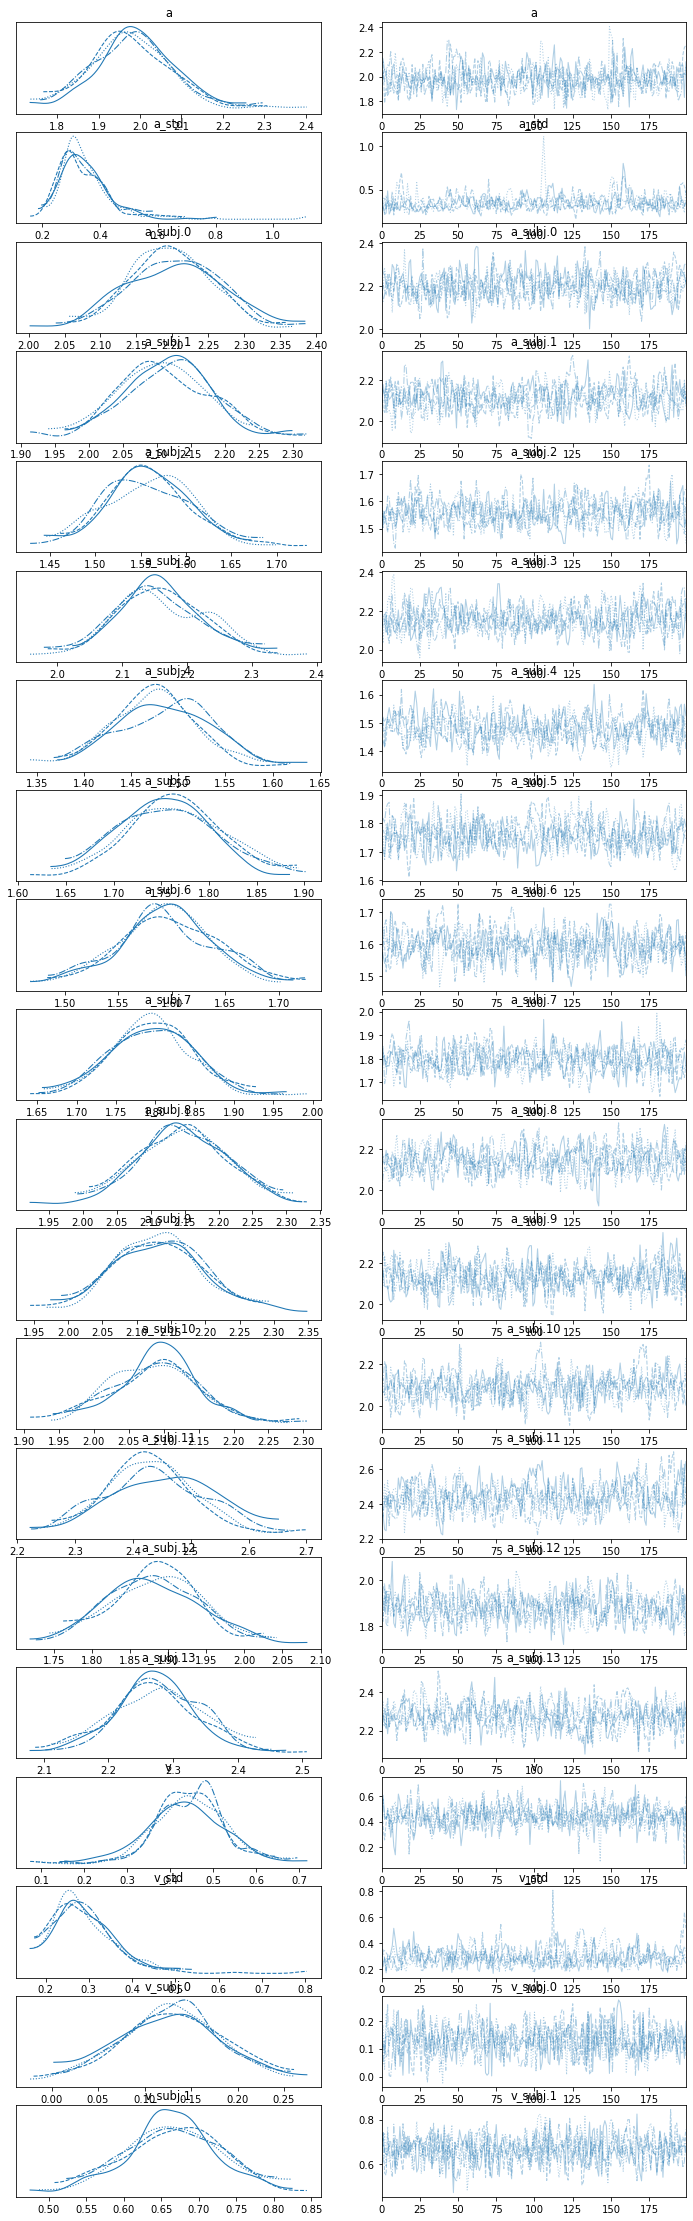

In [9]:
az.plot_trace(InfData['ms0'])

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

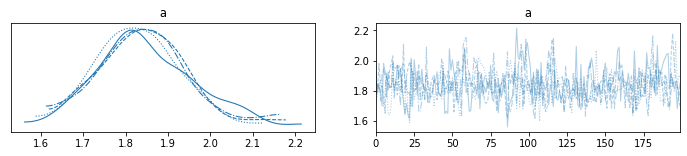

In [10]:
# using regex to select var_names that start with "a" 
#  and do not contain either "subj" or "std"
az.plot_trace(InfData['ms4'], var_names=("^a(?!.*(subj|std))"), filter_vars='regex')

#### Using `az.summary()` to check $\hat{R}$ and ESS

In [11]:
ms0_summary = az.summary(InfData['ms0'])
ms0_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_subj.5,0.497,0.072,0.359,0.616,0.003,0.002,742.0,474.0,1.00
v_subj.8,0.495,0.061,0.381,0.610,0.002,0.002,648.0,569.0,1.00
v_subj.7,0.030,0.066,-0.089,0.158,0.003,0.002,658.0,561.0,1.00
v_subj.11,0.592,0.060,0.491,0.713,0.002,0.002,639.0,550.0,1.00
v_subj.12,0.610,0.072,0.473,0.734,0.003,0.002,672.0,605.0,1.00
v_subj.4,0.950,0.090,0.770,1.101,0.004,0.003,534.0,588.0,1.00
v_subj.3,0.166,0.061,0.040,0.268,0.002,0.002,648.0,469.0,1.00
v_subj.13,0.218,0.058,0.117,0.330,0.002,0.002,691.0,595.0,1.00
v_subj.1,0.666,0.062,0.541,0.773,0.002,0.002,704.0,533.0,1.00
v_subj.0,0.129,0.055,0.035,0.241,0.002,0.001,800.0,512.0,1.00


In [12]:
ms4_summary = az.summary(InfData['ms4'])
ms4_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_std,0.383,0.085,0.252,0.555,0.005,0.003,338.0,516.0,1.00
t_std,0.111,0.028,0.065,0.163,0.001,0.001,550.0,499.0,1.00
a,1.841,0.105,1.636,2.022,0.005,0.004,413.0,531.0,1.01
v_Intercept_subj.9,0.547,0.097,0.368,0.722,0.006,0.004,274.0,362.0,1.01
a_subj.12,1.676,0.070,1.549,1.806,0.004,0.003,262.0,302.0,1.01
...,...,...,...,...,...,...,...,...,...
z_subj_trans.4,0.050,0.062,-0.050,0.178,0.012,0.008,26.0,264.0,1.12
z_subj_trans.10,0.103,0.067,0.001,0.227,0.013,0.009,22.0,117.0,1.14
z_subj_trans.1,0.064,0.059,-0.036,0.192,0.012,0.009,22.0,253.0,1.14
"v_C(conf, Treatment('LC'))[T.HC]_std",0.147,0.062,0.034,0.267,0.012,0.009,23.0,35.0,1.16


### Model comparison and selection

#### DIC

Here we record the DIC of each model in the models and sort by DIC.

In [13]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

CPU times: user 2.94 s, sys: 1.74 ms, total: 2.94 s
Wall time: 2.93 s


,rank,dic
0,ms4,10661.220706
1,ms0,10971.674846


#### PSIS-LOO-CV

In [14]:
comp_loo = az.compare(InfData, ic='loo')
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms4,0,-6171.947803,768.547165,0.000000,0.797389,338.180711,0.000000,True,log
ms0,1,-9127.846990,3611.073902,2955.899187,0.202611,1151.975702,1176.138058,True,log


####  WAIC

In [15]:
comp_waic = az.compare(InfData, ic='waic')
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ms4,0,-10849.001794,5445.601156,0.000000,0.794732,2749.286816,0.000000,True,log
ms0,1,-36936.149091,31419.376004,26087.147297,0.205268,11731.226740,12015.499794,True,log


#### Posterior predictive check

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

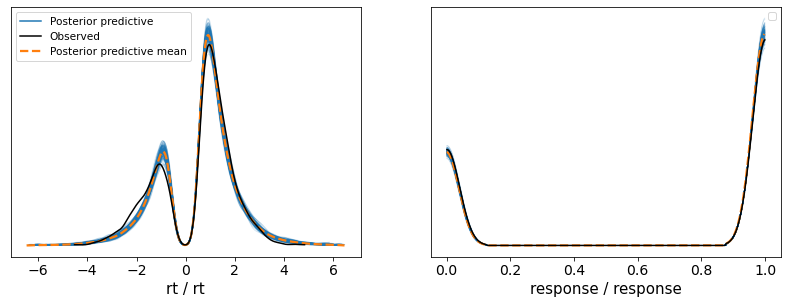

In [16]:
az.plot_ppc(InfData['ms0'])

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

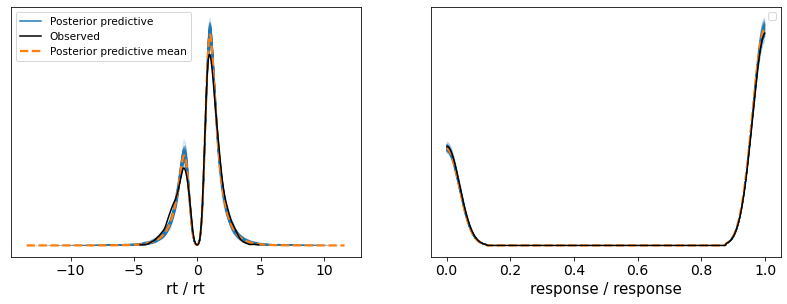

In [17]:
az.plot_ppc(InfData['ms4'])

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_1'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_1'>],
       [<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_0'>]],
      dtype=object)

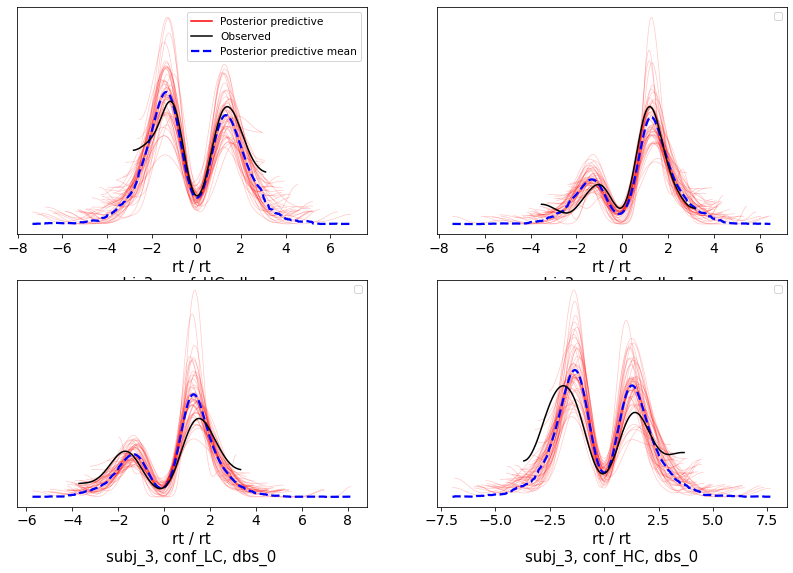

In [18]:
plot_ppc_by_cond(data = InfData['ms4'],
                 or_d = data_cavanagh,
                 subjs = [3],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_1'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_1'>],
       [<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_0'>]],
      dtype=object)

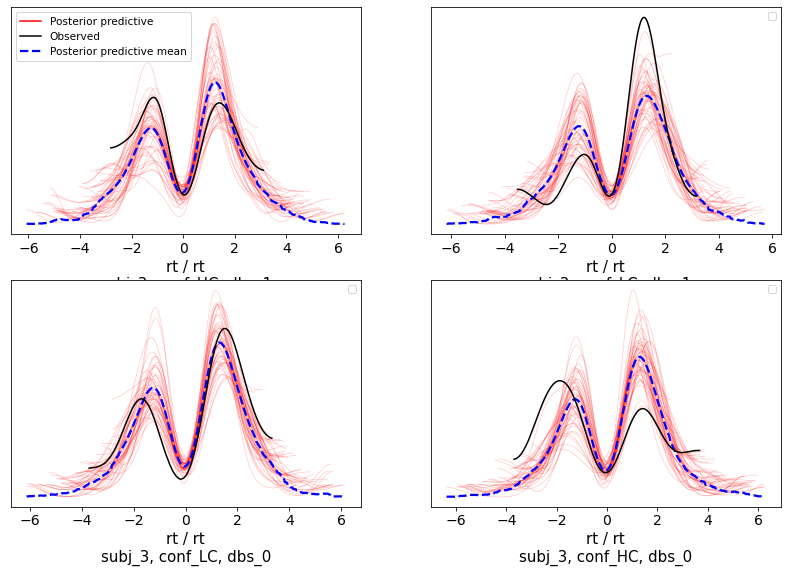

In [19]:
plot_ppc_by_cond(data = InfData['ms0'],
                 or_d = data_cavanagh,
                 subjs = [3],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

## Statistical Inference

array([[<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

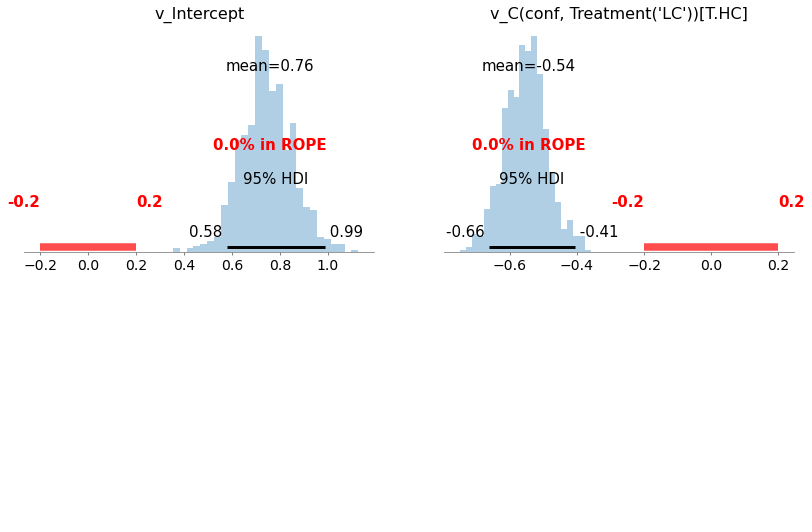

In [21]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.plot_posterior(InfData['ms4'], 
                  var_names=("^v_(?!.*(subj|std))"), 
                  filter_vars='regex',
                  grid = [2, 2], 
                  kind = 'hist',
                  hdi_prob = 0.95,
                  rope = [-0.2, 0.2], # assume this is our ROPE
                  rope_color = 'r')